In [16]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data and handle comments
df = pd.read_csv('server_metrics.csv', parse_dates=['timestamp'], comment='#')

# Clean any remaining comments in the cpu_usage column
df['cpu_usage'] = df['cpu_usage'].astype(str).str.split('#').str[0].str.strip()
df['cpu_usage'] = pd.to_numeric(df['cpu_usage'])

print("Data loaded successfully!")
print(f"Dataset shape: {df.shape}")
df.head()

Data loaded successfully!
Dataset shape: (24, 2)


,timestamp,cpu_usage
0,2025-08-01 00:00:00,15
1,2025-08-01 01:00:00,17
2,2025-08-01 02:00:00,14
3,2025-08-01 03:00:00,18
4,2025-08-01 04:00:00,20


=== Anomaly Detection Debug ===
Total data points: 24
Anomalies detected: 2
Anomaly threshold: 50%
Max CPU usage: 95%
Mean CPU usage: 23.8%

Anomaly details:
  Time: 08:00, CPU: 90%
  Time: 18:00, CPU: 95%


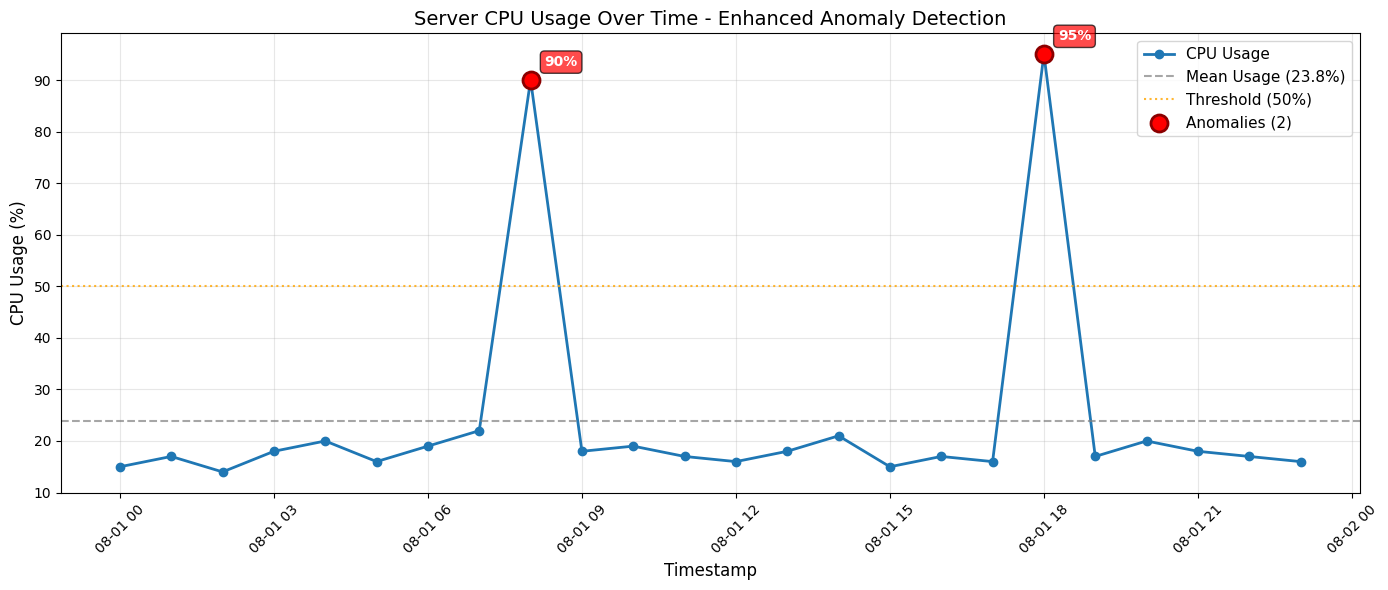

✅ Plot saved as 'cpu_anomaly_detection_plot.png'

Visualization complete! Anomalies should be clearly visible as red dots with annotations.


<Figure size 640x480 with 0 Axes>

In [ ]:
# Debug: Check if anomalies are being detected
print("=== Anomaly Detection Debug ===")
anomalies = df[df['cpu_usage'] > 50]
print(f"Total data points: {len(df)}")
print(f"Anomalies detected: {len(anomalies)}")
print(f"Anomaly threshold: 50%")
print(f"Max CPU usage: {df['cpu_usage'].max()}%")
print(f"Mean CPU usage: {df['cpu_usage'].mean():.1f}%")

if len(anomalies) > 0:
    print("\nAnomaly details:")
    for idx, row in anomalies.iterrows():
        print(f"  Time: {row['timestamp'].strftime('%H:%M')}, CPU: {row['cpu_usage']}%")
else:
    print("\nNo anomalies detected with current threshold!")

# Improved visualization with better anomaly highlighting
plt.figure(figsize=(14, 6))
plt.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=6, label='CPU Usage', linewidth=2)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('CPU Usage (%)', fontsize=12)
plt.title('Server CPU Usage Over Time - Enhanced Anomaly Detection', fontsize=14)
plt.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.7, label=f'Mean Usage ({df["cpu_usage"].mean():.1f}%)')
plt.axhline(y=50, color='orange', linestyle=':', alpha=0.8, label='Threshold (50%)')

# Enhanced anomaly highlighting
if len(anomalies) > 0:
    plt.scatter(anomalies['timestamp'], anomalies['cpu_usage'], 
               color='red', s=150, label=f'Anomalies ({len(anomalies)})', 
               zorder=5, edgecolors='darkred', linewidth=2)
    
    # Add text annotations for anomalies
    for idx, row in anomalies.iterrows():
        plt.annotate(f'{row["cpu_usage"]}%', 
                    (row['timestamp'], row['cpu_usage']), 
                    xytext=(10, 10), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                    fontsize=10, color='white', weight='bold')

plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nVisualization complete! Anomalies should be clearly visible as red dots with annotations.")

=== STEP 3: ISOLATION FOREST ANOMALY DETECTION ===
Isolation Forest detected: 3 anomalies
Contamination rate: 12.5%

Isolation Forest anomaly details:
  Time: 07:00, CPU: 22%, Score: -0.001
  Time: 08:00, CPU: 90%, Score: -0.139
  Time: 18:00, CPU: 95%, Score: -0.146


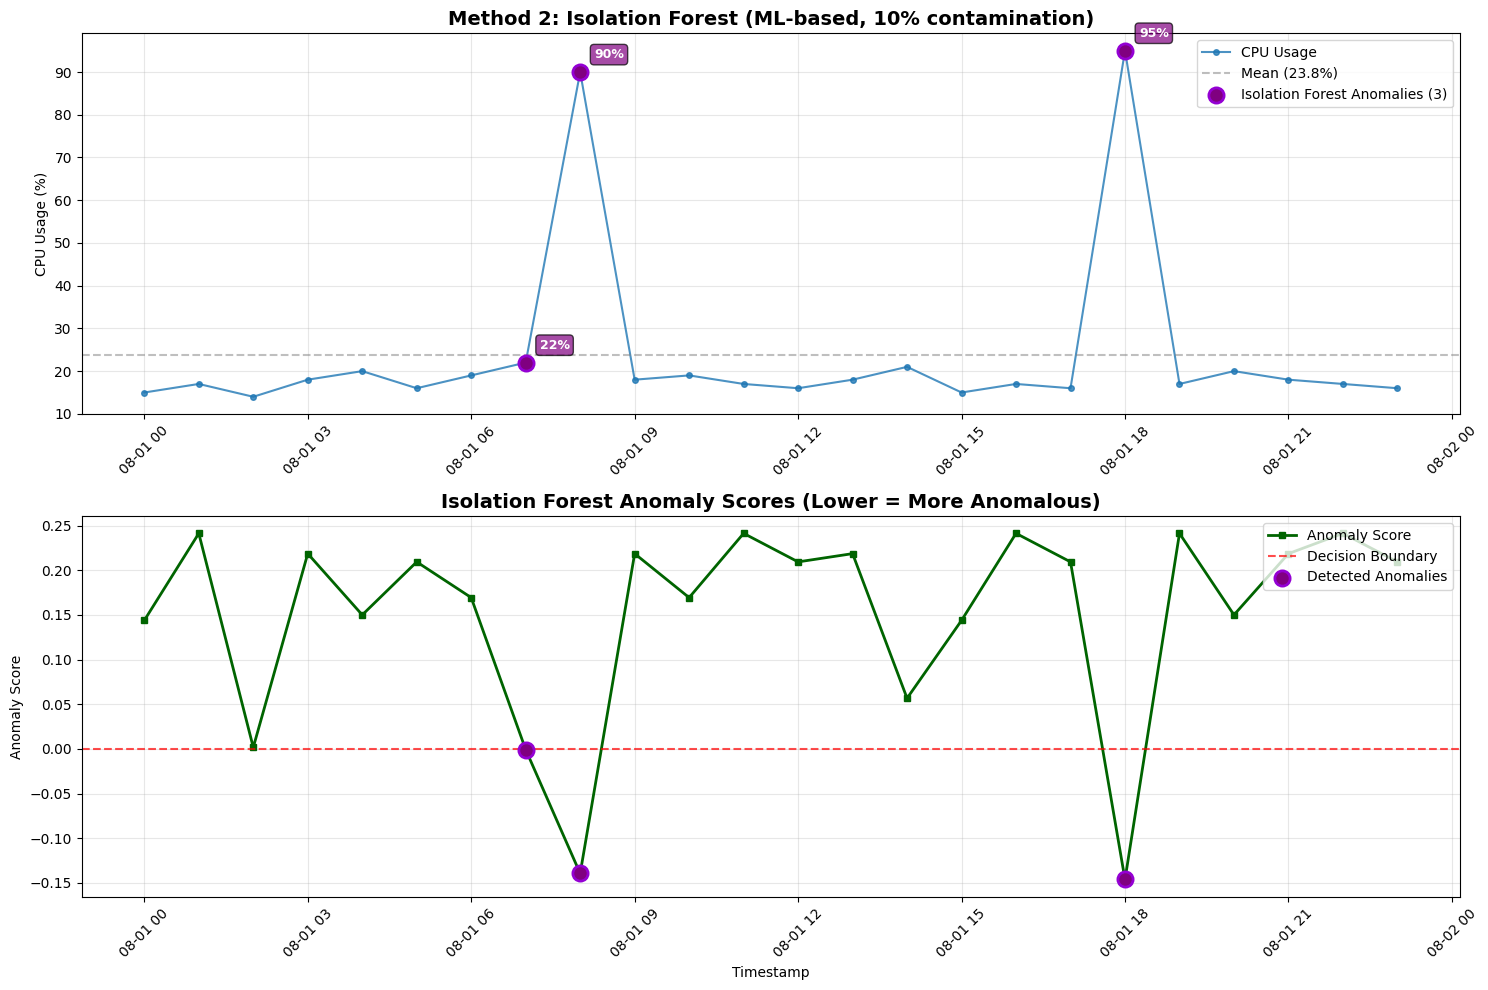


=== Method Comparison (Threshold vs Isolation Forest) ===
Threshold method: 2 anomalies
Isolation Forest: 3 anomalies
Common detections: 2 anomalies
Agreement rate: 66.7%


In [21]:
# Step 3: Isolation Forest Implementation and Visualization
from sklearn.ensemble import IsolationForest
import numpy as np

print("=== STEP 3: ISOLATION FOREST ANOMALY DETECTION ===")

# Prepare data for Isolation Forest (requires 2D array)
X = df[['cpu_usage']].values

# Initialize Isolation Forest with 10% contamination (expecting ~10% anomalies)
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=100)
anomaly_labels = iso_forest.fit_predict(X)

# Add results to dataframe (-1 = anomaly, 1 = normal)
df['anomaly_iso'] = anomaly_labels
df['is_anomaly_iso'] = df['anomaly_iso'] == -1

# Calculate anomaly scores (lower = more anomalous)
anomaly_scores = iso_forest.decision_function(X)
df['anomaly_score'] = anomaly_scores

# Display Isolation Forest results
iso_anomalies = df[df['is_anomaly_iso']]
print(f"Isolation Forest detected: {len(iso_anomalies)} anomalies")
print(f"Contamination rate: {len(iso_anomalies)/len(df)*100:.1f}%")

if len(iso_anomalies) > 0:
    print("\nIsolation Forest anomaly details:")
    for idx, row in iso_anomalies.iterrows():
        print(f"  Time: {row['timestamp'].strftime('%H:%M')}, CPU: {row['cpu_usage']}%, Score: {row['anomaly_score']:.3f}")

# Isolation Forest Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Isolation Forest Detection
ax1.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=4, label='CPU Usage', alpha=0.8)
ax1.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.5, label=f'Mean ({df["cpu_usage"].mean():.1f}%)')
ax1.scatter(iso_anomalies['timestamp'], iso_anomalies['cpu_usage'], 
           color='purple', s=120, label=f'Isolation Forest Anomalies ({len(iso_anomalies)})', 
           zorder=5, edgecolors='darkviolet', linewidth=2)

# Add annotations for anomalies
for idx, row in iso_anomalies.iterrows():
    ax1.annotate(f'{row["cpu_usage"]}%', 
                (row['timestamp'], row['cpu_usage']), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='purple', alpha=0.7),
                fontsize=9, color='white', weight='bold')

ax1.set_title('Method 2: Isolation Forest (ML-based, 10% contamination)', fontsize=14, weight='bold')
ax1.set_ylabel('CPU Usage (%)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Anomaly Scores
ax2.plot(df['timestamp'], df['anomaly_score'], marker='s', markersize=4, 
         color='darkgreen', label='Anomaly Score', linewidth=2)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
ax2.scatter(iso_anomalies['timestamp'], iso_anomalies['anomaly_score'], 
           color='purple', s=120, label='Detected Anomalies', zorder=5,
           edgecolors='darkviolet', linewidth=2)
ax2.set_title('Isolation Forest Anomaly Scores (Lower = More Anomalous)', fontsize=14, weight='bold')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Anomaly Score')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Rotate x-axis labels for both plots
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Compare with threshold method
threshold_anomalies = df[df['cpu_usage'] > 50]
common_anomalies = len(set(iso_anomalies.index) & set(threshold_anomalies.index))

print(f"\n=== Method Comparison (Threshold vs Isolation Forest) ===")
print(f"Threshold method: {len(threshold_anomalies)} anomalies")
print(f"Isolation Forest: {len(iso_anomalies)} anomalies")
print(f"Common detections: {common_anomalies} anomalies")
print(f"Agreement rate: {common_anomalies/max(len(threshold_anomalies), len(iso_anomalies))*100:.1f}%")

=== STEP 4: ONE-CLASS SVM ANOMALY DETECTION ===
Applying One-Class SVM...
One-Class SVM detected: 2 anomalies
Contamination rate: 8.3%

One-Class SVM anomaly details:
  Time: 02:00, CPU: 14%, Score: -0.000
  Time: 07:00, CPU: 22%, Score: -0.000


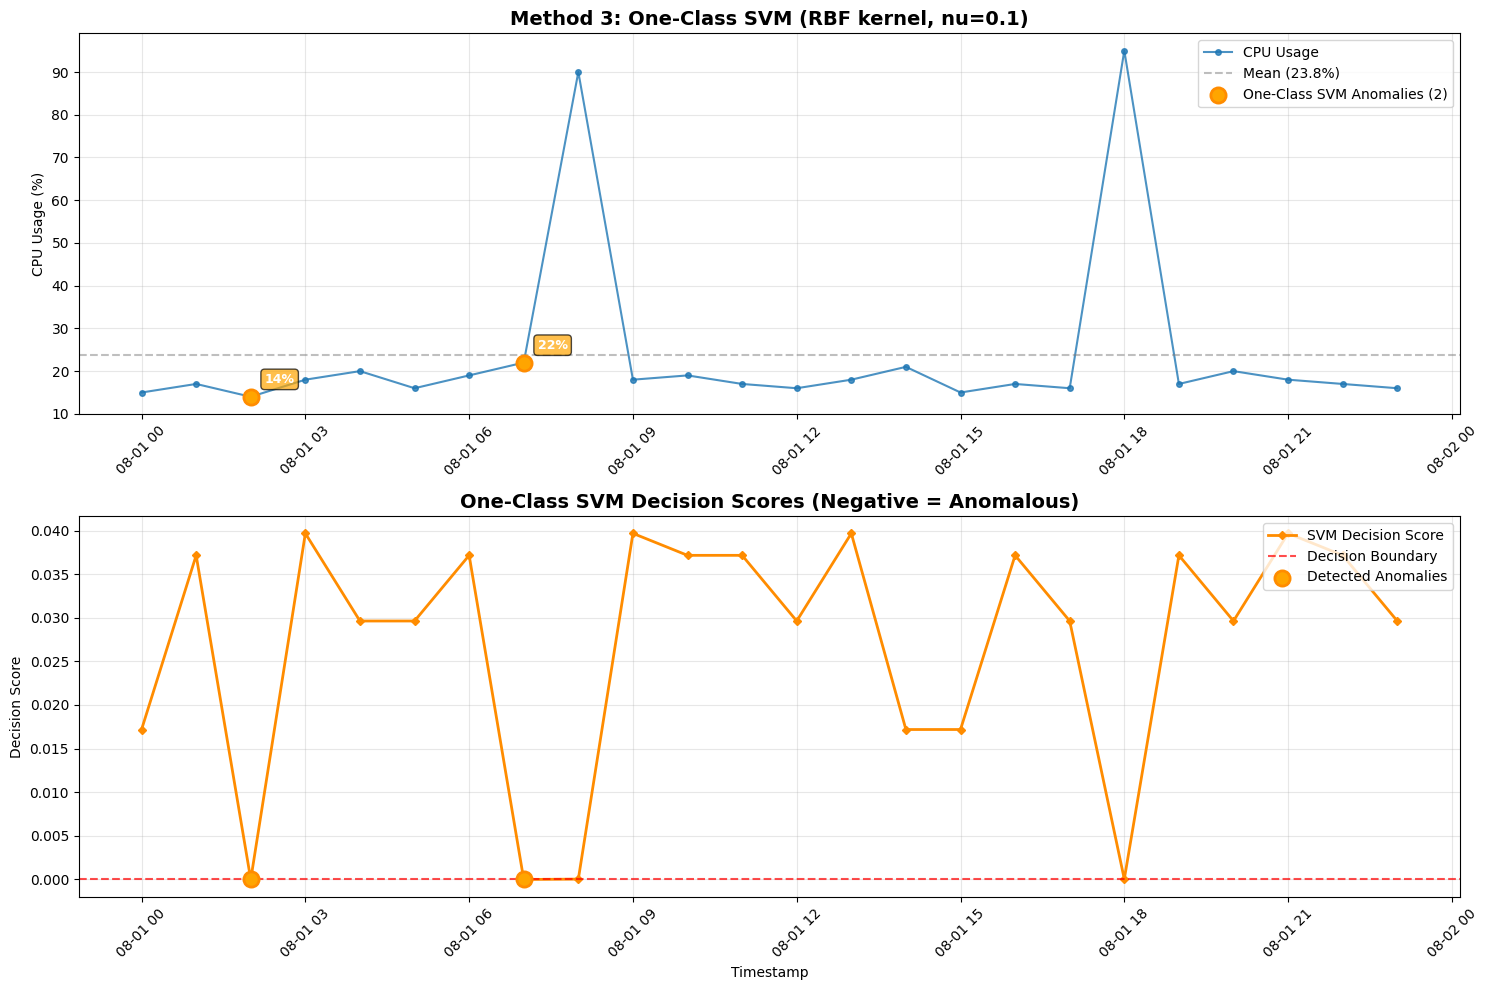


=== One-Class SVM Analysis Complete ===


In [22]:
# Step 4: One-Class SVM Implementation and Visualization
from sklearn.svm import OneClassSVM
import numpy as np

print("=== STEP 4: ONE-CLASS SVM ANOMALY DETECTION ===")

# Apply One-Class SVM
print("Applying One-Class SVM...")
svm_model = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
svm_predictions = svm_model.fit_predict(df[['cpu_usage']])
df['svm_anomaly'] = svm_predictions == -1

# Get SVM decision scores
svm_scores = svm_model.decision_function(df[['cpu_usage']])
df['svm_score'] = svm_scores

# Extract hour for analysis
df['hour'] = df['timestamp'].dt.hour

# Display SVM results
svm_anomalies = df[df['svm_anomaly']]
print(f"One-Class SVM detected: {len(svm_anomalies)} anomalies")
print(f"Contamination rate: {len(svm_anomalies)/len(df)*100:.1f}%")

if len(svm_anomalies) > 0:
    print("\nOne-Class SVM anomaly details:")
    for idx, row in svm_anomalies.iterrows():
        print(f"  Time: {row['timestamp'].strftime('%H:%M')}, CPU: {row['cpu_usage']}%, Score: {row['svm_score']:.3f}")

# One-Class SVM Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: One-Class SVM Detection
ax1.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=4, label='CPU Usage', alpha=0.8)
ax1.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.5, label=f'Mean ({df["cpu_usage"].mean():.1f}%)')
ax1.scatter(svm_anomalies['timestamp'], svm_anomalies['cpu_usage'], 
           color='orange', s=120, label=f'One-Class SVM Anomalies ({len(svm_anomalies)})', 
           zorder=5, edgecolors='darkorange', linewidth=2)

# Add annotations for anomalies
for idx, row in svm_anomalies.iterrows():
    ax1.annotate(f'{row["cpu_usage"]}%', 
                (row['timestamp'], row['cpu_usage']), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.7),
                fontsize=9, color='white', weight='bold')

ax1.set_title('Method 3: One-Class SVM (RBF kernel, nu=0.1)', fontsize=14, weight='bold')
ax1.set_ylabel('CPU Usage (%)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: SVM Decision Scores
ax2.plot(df['timestamp'], df['svm_score'], marker='D', markersize=4, 
         color='darkorange', label='SVM Decision Score', linewidth=2)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Decision Boundary')
ax2.scatter(svm_anomalies['timestamp'], svm_anomalies['svm_score'], 
           color='orange', s=120, label='Detected Anomalies', zorder=5,
           edgecolors='darkorange', linewidth=2)
ax2.set_title('One-Class SVM Decision Scores (Negative = Anomalous)', fontsize=14, weight='bold')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Decision Score')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Rotate x-axis labels for both plots
for ax in [ax1, ax2]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n=== One-Class SVM Analysis Complete ===")

=== STEP 5: COMPREHENSIVE METHOD COMPARISON ===
THREE-METHOD COMPARISON:
  - Threshold method: 2 anomalies
  - Isolation Forest: 3 anomalies
  - One-Class SVM: 2 anomalies

ALGORITHM AGREEMENT ANALYSIS:
  - Threshold ∩ Isolation Forest: 2 common anomalies
  - Threshold ∩ One-Class SVM: 0 common anomalies
  - Isolation Forest ∩ One-Class SVM: 1 common anomalies
  - All three methods agree: 0 anomalies



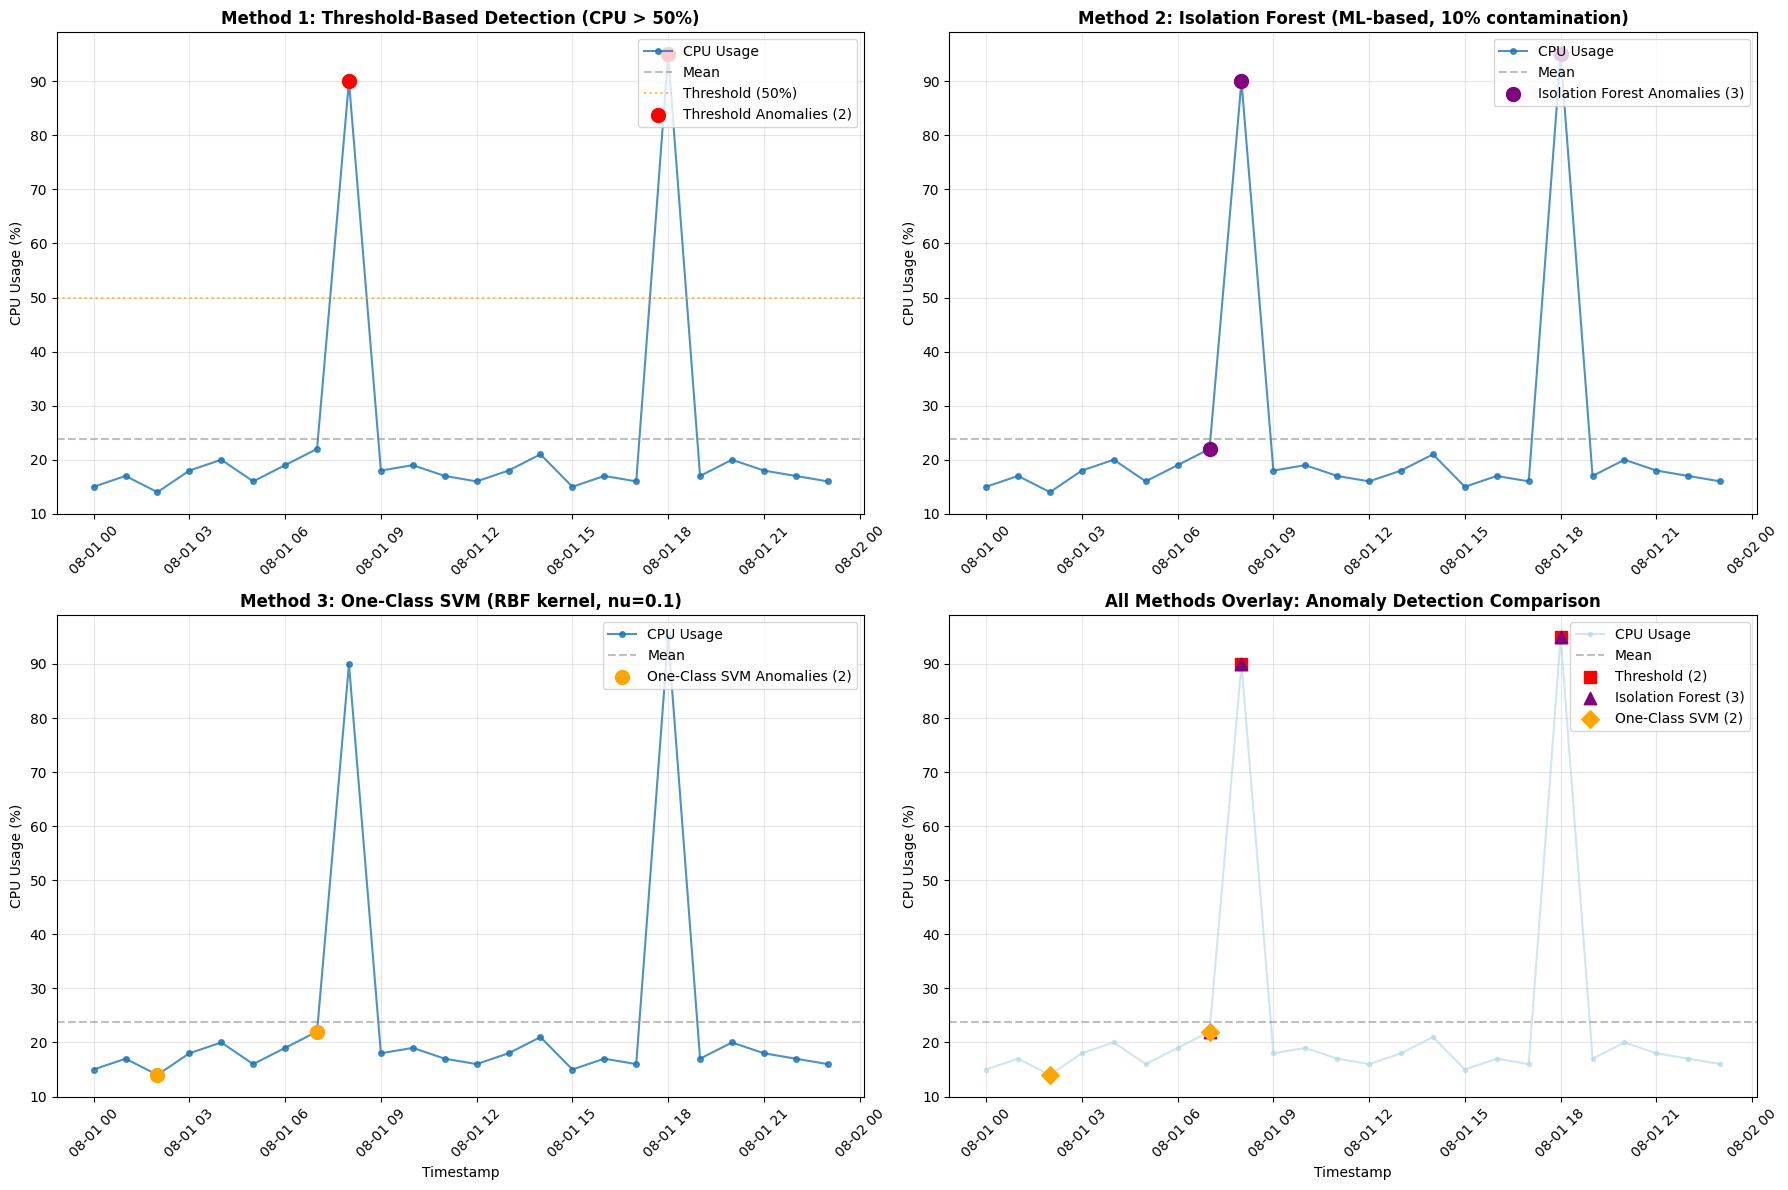


=== FINAL ANALYSIS SUMMARY ===
Dataset: 24 hourly measurements
Normal baseline: 17.5% ± 2.0%

Detection Results:
  - Threshold method: 2 anomalies
  - Isolation Forest: 3 anomalies
  - One-Class SVM: 2 anomalies

Unique Detections:
  - Only Threshold: None
  - Only Isolation Forest: None
  - Only One-Class SVM: [2]

Most extreme points:
  - Highest CPU: 18:00 (95%)
  - Lowest CPU: 02:00 (14%)

=== ANALYSIS COMPLETE ===


In [23]:
# Step 5: Comprehensive Method Comparison and Analysis
print("=== STEP 5: COMPREHENSIVE METHOD COMPARISON ===")

# Get anomalies from all three methods
threshold_anomalies = df[df['cpu_usage'] > 50]
iso_anomalies = df[df['is_anomaly_iso']]
svm_anomalies = df[df['svm_anomaly']]

# Algorithm comparison summary
print("THREE-METHOD COMPARISON:")
print(f"  - Threshold method: {len(threshold_anomalies)} anomalies")
print(f"  - Isolation Forest: {len(iso_anomalies)} anomalies")
print(f"  - One-Class SVM: {len(svm_anomalies)} anomalies")
print()

# Calculate agreement between all methods
threshold_hours = set(threshold_anomalies['hour'])
iso_hours = set(iso_anomalies['hour'])
svm_hours = set(svm_anomalies['hour'])

# Pairwise agreements
thresh_iso_agreement = len(threshold_hours.intersection(iso_hours))
thresh_svm_agreement = len(threshold_hours.intersection(svm_hours))
iso_svm_agreement = len(iso_hours.intersection(svm_hours))
all_three_agreement = len(threshold_hours.intersection(iso_hours).intersection(svm_hours))

print("ALGORITHM AGREEMENT ANALYSIS:")
print(f"  - Threshold ∩ Isolation Forest: {thresh_iso_agreement} common anomalies")
print(f"  - Threshold ∩ One-Class SVM: {thresh_svm_agreement} common anomalies")
print(f"  - Isolation Forest ∩ One-Class SVM: {iso_svm_agreement} common anomalies")
print(f"  - All three methods agree: {all_three_agreement} anomalies")
print()

# Comprehensive Comparison Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Threshold-based detection
ax1.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=4, label='CPU Usage', alpha=0.8)
ax1.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax1.axhline(y=50, color='orange', linestyle=':', alpha=0.7, label='Threshold (50%)')
ax1.scatter(threshold_anomalies['timestamp'], threshold_anomalies['cpu_usage'], 
           color='red', s=100, label=f'Threshold Anomalies ({len(threshold_anomalies)})', zorder=5)
ax1.set_title('Method 1: Threshold-Based Detection (CPU > 50%)', fontsize=12, weight='bold')
ax1.set_ylabel('CPU Usage (%)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Isolation Forest detection
ax2.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=4, label='CPU Usage', alpha=0.8)
ax2.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax2.scatter(iso_anomalies['timestamp'], iso_anomalies['cpu_usage'], 
           color='purple', s=100, label=f'Isolation Forest Anomalies ({len(iso_anomalies)})', zorder=5)
ax2.set_title('Method 2: Isolation Forest (ML-based, 10% contamination)', fontsize=12, weight='bold')
ax2.set_ylabel('CPU Usage (%)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: One-Class SVM detection
ax3.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=4, label='CPU Usage', alpha=0.8)
ax3.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')
ax3.scatter(svm_anomalies['timestamp'], svm_anomalies['cpu_usage'], 
           color='orange', s=100, label=f'One-Class SVM Anomalies ({len(svm_anomalies)})', zorder=5)
ax3.set_title('Method 3: One-Class SVM (RBF kernel, nu=0.1)', fontsize=12, weight='bold')
ax3.set_ylabel('CPU Usage (%)')
ax3.set_xlabel('Timestamp')
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Plot 4: All methods comparison overlay
ax4.plot(df['timestamp'], df['cpu_usage'], marker='o', markersize=3, label='CPU Usage', alpha=0.6, color='lightblue')
ax4.axhline(y=df['cpu_usage'].mean(), color='gray', linestyle='--', alpha=0.5, label='Mean')

# Add all anomalies with different shapes and colors
ax4.scatter(threshold_anomalies['timestamp'], threshold_anomalies['cpu_usage'], 
           color='red', s=80, label=f'Threshold ({len(threshold_anomalies)})', zorder=5, marker='s')
ax4.scatter(iso_anomalies['timestamp'], iso_anomalies['cpu_usage'], 
           color='purple', s=80, label=f'Isolation Forest ({len(iso_anomalies)})', zorder=5, marker='^')
ax4.scatter(svm_anomalies['timestamp'], svm_anomalies['cpu_usage'], 
           color='orange', s=80, label=f'One-Class SVM ({len(svm_anomalies)})', zorder=5, marker='D')

ax4.set_title('All Methods Overlay: Anomaly Detection Comparison', fontsize=12, weight='bold')
ax4.set_ylabel('CPU Usage (%)')
ax4.set_xlabel('Timestamp')
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Rotate x-axis labels for all plots
for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Final comprehensive summary
print(f"\n=== FINAL ANALYSIS SUMMARY ===")
print(f"Dataset: {len(df)} hourly measurements")
print(f"Normal baseline: {df[df['cpu_usage'] <= 30]['cpu_usage'].mean():.1f}% ± {df[df['cpu_usage'] <= 30]['cpu_usage'].std():.1f}%")
print(f"\nDetection Results:")
print(f"  - Threshold method: {len(threshold_anomalies)} anomalies")
print(f"  - Isolation Forest: {len(iso_anomalies)} anomalies") 
print(f"  - One-Class SVM: {len(svm_anomalies)} anomalies")

# Unique detections by each method
unique_threshold = threshold_hours - iso_hours - svm_hours
unique_iso = iso_hours - threshold_hours - svm_hours
unique_svm = svm_hours - threshold_hours - iso_hours

print(f"\nUnique Detections:")
print(f"  - Only Threshold: {list(unique_threshold) if unique_threshold else 'None'}")
print(f"  - Only Isolation Forest: {list(unique_iso) if unique_iso else 'None'}")
print(f"  - Only One-Class SVM: {list(unique_svm) if unique_svm else 'None'}")

print(f"\nMost extreme points:")
print(f"  - Highest CPU: {df.loc[df['cpu_usage'].idxmax(), 'timestamp'].strftime('%H:%M')} ({df['cpu_usage'].max()}%)")
print(f"  - Lowest CPU: {df.loc[df['cpu_usage'].idxmin(), 'timestamp'].strftime('%H:%M')} ({df['cpu_usage'].min()}%)")

print(f"\n=== ANALYSIS COMPLETE ===")